# Walk Through QMF Compression Pipeline

In this notebook, we will read an image, convert it to YCbCr color space, downsample the chroma channels, and apply quantization-aware matrix factorization (QMF) to get the factors and visualize the components and coefficients.

In [1]:
import torch
from einops import rearrange
from matplotlib.colors import Normalize
import lrf

/Users/pooya/opt/miniconda3/envs/deepenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Image

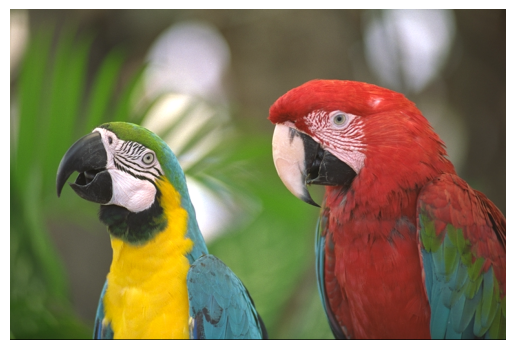

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [2]:
image = lrf.read_image("./data/kodak/kodim23.png")
lrf.vis_image(image)

## YC<sub>B</sub>C<sub>R</sub> Color Space Transform

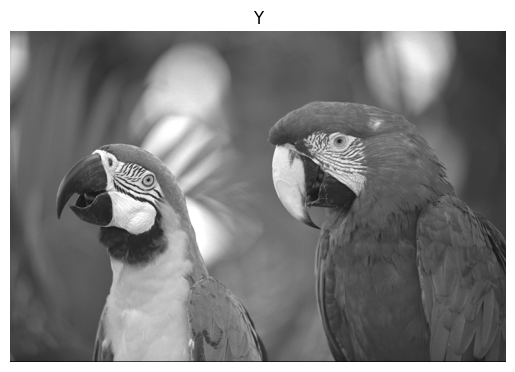

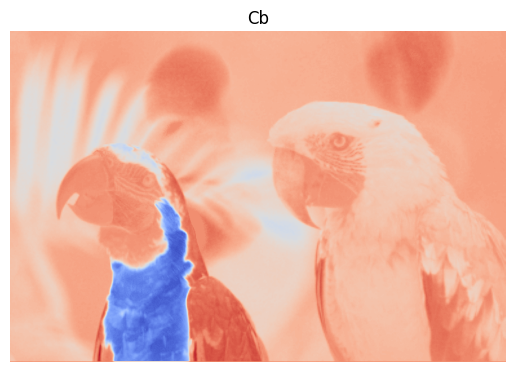

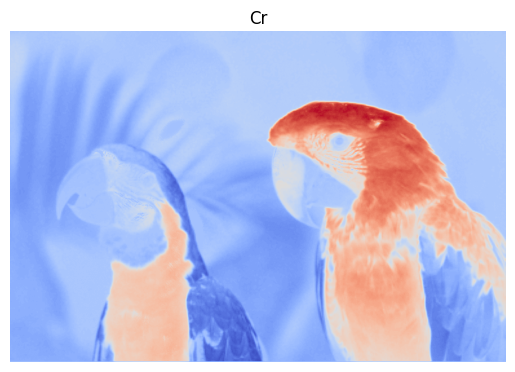

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Cr'}>)

In [3]:
ycbcr = lrf.rgb_to_ycbcr(image) / 255
y, cb, cr = ycbcr[0:1], ycbcr[1:2], ycbcr[2:3]

lrf.vis_image(y, title="Y", cmap="gray")
lrf.vis_image(cb, title="Cb", cmap="coolwarm")
lrf.vis_image(cr, title="Cr", cmap="coolwarm")

## Chroma Downsample

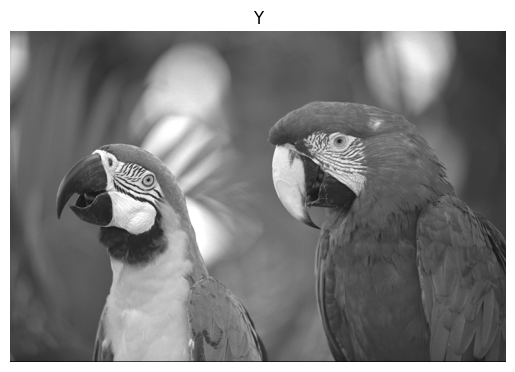

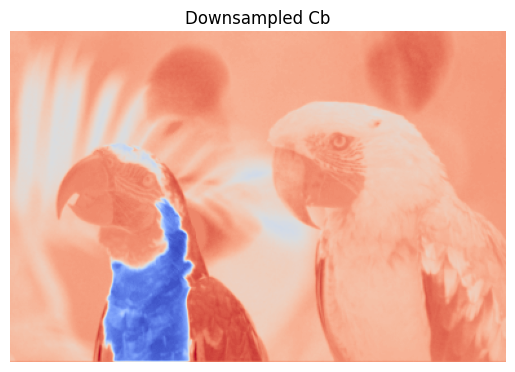

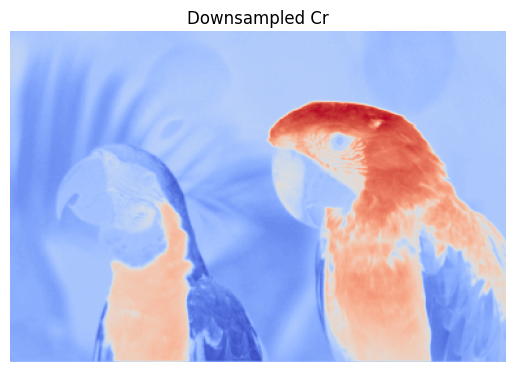

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Downsampled Cr'}>)

In [4]:
y, cb, cr = lrf.chroma_downsampling(ycbcr, scale_factor=(0.5, 0.5), mode="area")

lrf.vis_image(y, title="Y", cmap="gray")
lrf.vis_image(cb, title="Downsampled Cb", cmap="coolwarm")
lrf.vis_image(cr, title="Downsampled Cr", cmap="coolwarm")

## Patchify

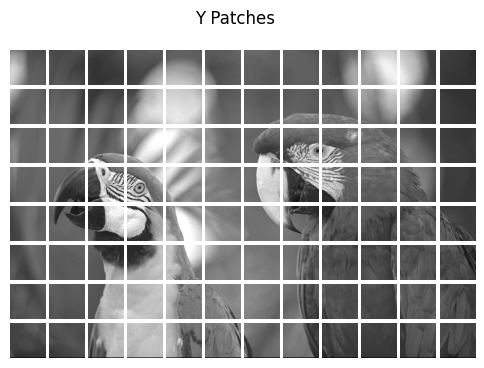

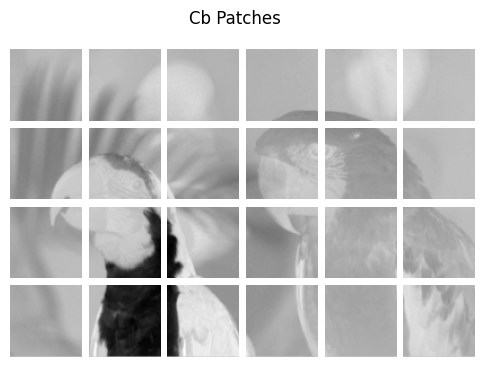

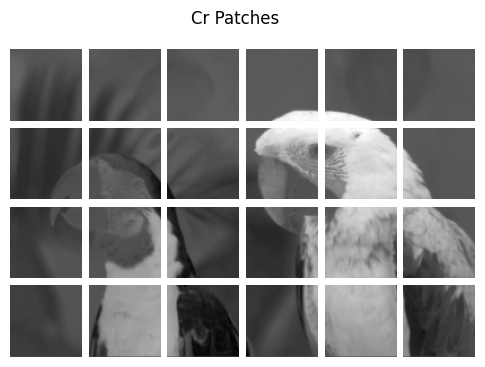

In [5]:
patch_size = p, q = (64, 64)
image_size = image.shape[-2:]

h, w = y.shape[-2:]
x_y = rearrange(y, "c (h p) (w q) -> (h w) c p q", p=p, q=q)
fig, axs = lrf.vis_image_batch(
    x_y,
    title="Y Patches",
    grid_size=(h // p, w // q),
    cmap="gray",
    norm=Normalize(vmin=y.min(), vmax=y.max()),
)

h, w = cb.shape[-2:]
x_cb = rearrange(cb, "c (h p) (w q) -> (h w) c p q", p=p, q=q)
fig, axs = lrf.vis_image_batch(
    x_cb,
    title="Cb Patches",
    grid_size=(h // p, w // q),
    cmap="gray",
    norm=Normalize(vmin=cb.min(), vmax=cb.max()),
)

h, w = cr.shape[-2:]
x_cr = rearrange(cr, "c (h p) (w q) -> (h w) c p q", p=p, q=q)
fig, axs = lrf.vis_image_batch(
    x_cr,
    title="Cr Patches",
    grid_size=(h // p, w // q),
    cmap="gray",
    norm=Normalize(vmin=cr.min(), vmax=cr.max()),
)

## Apply Quantization-aware Matrix Factorization (QMF)

Now, we apply can QMF to decompose each of these matrices (`x_y`, `x_cb`, `x_cr`) into two bounded integer factor matrices `u` (components) and `v` (coefficients).

In [6]:
encoded_image = lrf.qmf_encode(
    image,
    color_space="YCbCr",
    scale_factor=(0.5, 0.5),
    rank=(4, 2, 2),
    patch=True,
    patch_size=(8, 8),
    bounds=(-16, 15),
    dtype=torch.int8,
    num_iters=10,
    verbose=False,
)
encoded_metadata, encoded_factors = lrf.separate_bytes(encoded_image, 2)
metadata = lrf.bytes_to_dict(encoded_metadata)
encoded_factors = lrf.separate_bytes(encoded_factors, 6)

u_y, v_y = lrf.decode_tensor(encoded_factors[0]), lrf.decode_tensor(encoded_factors[1])
u_cb, v_cb = lrf.decode_tensor(encoded_factors[2]), lrf.decode_tensor(encoded_factors[3])
u_cr, v_cr = lrf.decode_tensor(encoded_factors[4]), lrf.decode_tensor(encoded_factors[5])

## Depatchify QMF Components and Coefficients Matrices

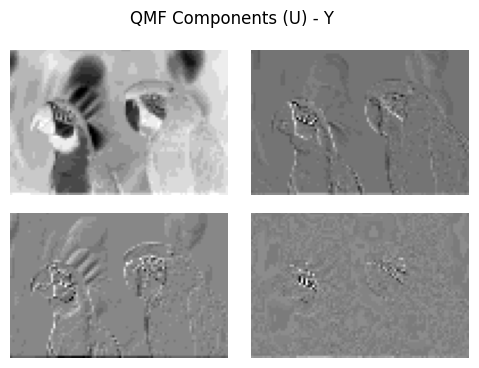

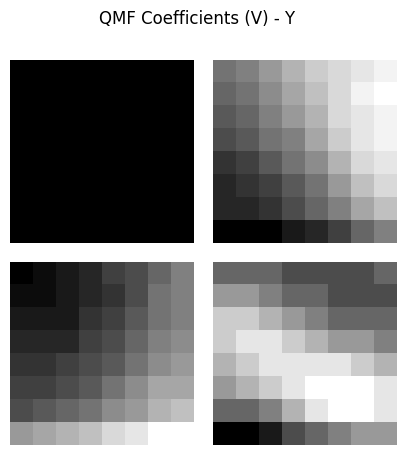

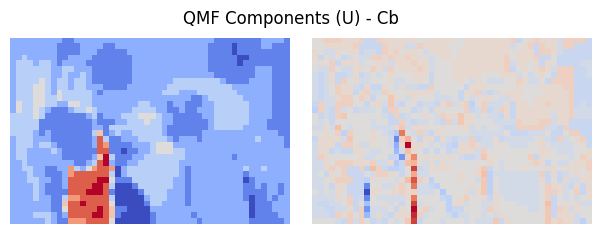

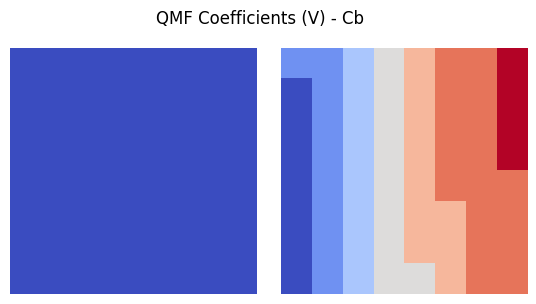

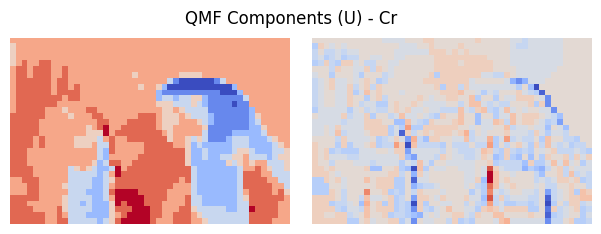

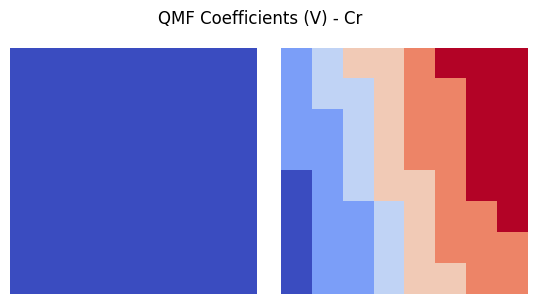

(<Figure size 666.667x333.333 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

In [7]:
patch_size = metadata["patch size"]
y_size, cb_size, cr_size = metadata["original size"]

u_y, v_y = lrf.depatchify_uv(u_y, v_y, y_size, patch_size)
lrf.vis_image_batch(u_y, title="QMF Components (U) - Y", cmap="gray")
lrf.vis_image_batch(v_y, title="QMF Coefficients (V) - Y", cmap="gray")

u_cb, v_cb = lrf.depatchify_uv(u_cb, v_cb, cb_size, patch_size)
lrf.vis_image_batch(u_cb, title="QMF Components (U) - Cb", cmap="coolwarm")
lrf.vis_image_batch(v_cb, title="QMF Coefficients (V) - Cb", cmap="coolwarm")

u_cr, v_cr = lrf.depatchify_uv(u_cr, v_cr, cr_size, patch_size)
lrf.vis_image_batch(u_cr, title="QMF Components (U) - Cr", cmap="coolwarm")
lrf.vis_image_batch(v_cr, title="QMF Coefficients (V) - Cr", cmap="coolwarm")

## Calculate Rank-1 Terms

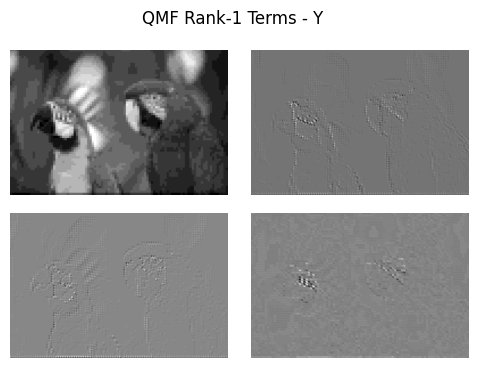

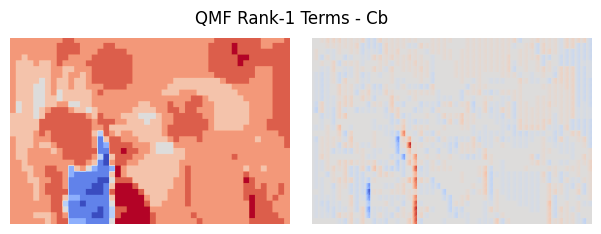

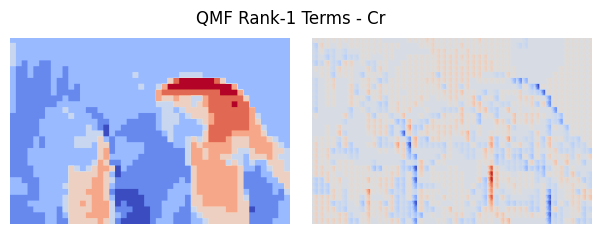

(<Figure size 750x250 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [8]:
def calculate_rank1_terms(u, v):
    u, v = u.float(), v.float()
    rank1_terms = torch.einsum("r c h w, r c p q -> r c h p w q", u, v)
    return rearrange(rank1_terms, "r c h p w q -> r c (h p) (w q)")

x_y = calculate_rank1_terms(u_y, v_y)
lrf.vis_image_batch(x_y, title="QMF Rank-1 Terms - Y", cmap="gray")

x_cb = calculate_rank1_terms(u_cb, v_cb)
lrf.vis_image_batch(x_cb, title="QMF Rank-1 Terms - Cb", cmap="coolwarm")

x_cr = calculate_rank1_terms(u_cr, v_cr)
lrf.vis_image_batch(x_cr, title="QMF Rank-1 Terms - Cr", cmap="coolwarm")